In [1]:
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import time

# Import & create graph

In [2]:
edgelist = pd.read_csv('edgelist.csv')

In [3]:
DG = nx.from_pandas_edgelist(edgelist, source = "source", target = "destination", edge_attr = "weight", create_using = nx.DiGraph())

In [4]:
def form_wards(blocks, start_floor, end_floor):
    blocklist = blocks
    floorlist = [floor for floor in range(start_floor,end_floor+1)]

    unique_combinations = []

    for block in range(len(blocklist)):
        for floor in range(len(floorlist)):
            unique_combinations.append(blocklist[block]+str(floorlist[floor]))

    return unique_combinations

AB_2_6 = form_wards (["A", "B", "C","D"],2,6)
AB_7_10 = form_wards (["A", "B", "C"],7,10)
AB_others = ['A11','C11','ALG','A1']
EF_2_10 = form_wards (["E", "F", "G","H"],2,10)
EF_others = ['E11','G11','G1','H1']
ward_list = list(itertools.chain(AB_2_6,AB_7_10,AB_others,EF_2_10,EF_others))
ward_list.sort()

def form_liftfloors (blockprefix, start_floor, end_floor, add_floorlist):
    floorlist = list(map(str,list(range(start_floor, end_floor+1))))
    floorlist.extend(add_floorlist)
    prefixedlist=[blockprefix + floor for floor in floorlist]
    return prefixedlist

liftfloor_list = form_liftfloors (blockprefix = 'Lift_AB_', start_floor = 1, end_floor = 11, add_floorlist = ['G','LG'])
liftfloor_list.extend(form_liftfloors (blockprefix = 'Lift_EF_', start_floor = 1, end_floor = 11, add_floorlist = ['G','LG']))

labels = 'unspecified'
nx.set_node_attributes(DG, labels, 'nature')
for ward in ward_list:
    DG.add_node(ward)
    DG.nodes[ward]['nature'] = 'ward'
for liftfloor in liftfloor_list:
    DG.add_node(liftfloor)
    DG.nodes[liftfloor]['nature'] = 'lift_lobby'

Function (add_doubleedges) allows adding additional connections.

In [5]:
def add_doubleedges(graph, source, destination, edgeweight):
    graph.add_edge(source, destination, weight = edgeweight)
    graph.add_edge(destination, source, weight = edgeweight)
add_doubleedges(DG, 'Lift_AB_1', 'Lift_EF_1', edgeweight = 5)
add_doubleedges(DG, 'Lift_AB_LG','Lift_EF_LG', edgeweight = 5)
add_doubleedges(DG, 'Lift_EF_1', 'H1', edgeweight = 5)

The following are the output functions:
Function (get_shortest_path) returns the shortest path in list format.
Function (get_shortest_path_length) returns the shortest time-distance cost between the selected pair of vertices.
The distance are calculated using Dijkstra's Algorithm.

Example:
get_shortest_path_length(graph,'A10','E5') will return the shortest time-distance between ward A10 and E5: 31 units
get_shortest_path(graph,'A10','E5') will return the actual path: ['A10', 'B10', 'Lift_AB_10', 'Lift_AB_5', 'C5', 'E5']


In [6]:
def get_shortest_path(graph, source, destination):
    shortest_path = nx.dijkstra_path(graph, source=source, target=destination, weight='weight')
    return shortest_path
def get_shortest_path_length(graph, source, destination):
    shortest_path = nx.dijkstra_path_length(graph, source=source, target=destination, weight='weight')
    if shortest_path == 0:shortest_path = 1e7
    return shortest_path

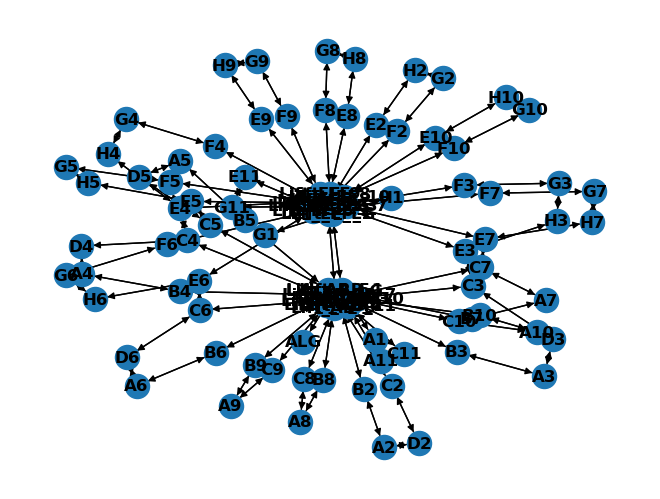

In [7]:
nx.draw(DG, with_labels=True, font_weight='bold')
plt.show()

# Generate dummy requests

In [8]:
# Generate dummy requests
from scipy.stats import gamma

np.random.seed(0)
requests_wards = pd.DataFrame(ward_list, columns = ["Ward"])
requests_wards["Request"] = np.int64(np.floor(gamma.rvs(a=5.4, size=len(ward_list))))

for i in range(len(ward_list)):
    elimination = np.random.randint(0, 2, size=(len(ward_list), 1))
    if elimination[i] == 0:requests_wards.loc[i, "Request"] = 0

requests_wards["Time"] = requests_wards["Request"].apply(lambda x: 2 * x)

In [36]:
requests_wards

,Ward,Request,Time
0,A1,0,0
1,A10,6,12
2,A11,10,20
3,A2,0,0
4,A3,0,0
...,...,...,...
71,H5,10,20
72,H6,0,0
73,H7,0,0
74,H8,0,0


# Set up the objective function

## Rationale of the Objective Function

### Reward

The total number of requests fulfilled after optimisation

### Costs

+ Total travel time
+ Imbalance of workload among different shifts
+ Overtime **(for SOFT overtime constraint only)**

### Objective

Maximise **net reward** *(reward - costs)*

<div style="page-break-after: always;"></div>

## Parameters

### Hyperparameters

+ $r$: Reward parameter for each request fulfilled
+ $\alpha$: Cost parameter for travel time
+ $\beta$: Cost parameter for imbalanced workload among different radiography team shifts
+ $k$: Cost parameter for working overtime and underload

### Parameters Determined After Optimisation

+ $n_i$: Number of requests fulfilled during Shift $i$
+ $t_i$: Travel time spent during Shift $i$
+ $T_i$: Time spent on patients during Shift $i$

### Fixed Parameters

+ $s$: Number of shifts considered in the optimisation
+ $T$: Duration allowed for one shift
+ $T_o$: Maximum tolerable overtime duration
+ $T_u$: Maximum tolerable underload duration


## Objective Function

$$max \sum_{i=1}^{s} [rn_i - (\alpha t_i + \beta |n_i - \frac{1}{s}\sum_{i=1}^{s} n_i| + ot_i + ut_i)] $$
$$\text{Where } 
ot_i = 
\begin{cases} 
& 0, T_i + t_i - T < T_o \\
& k(T_i + t_i - T)^2, T_i + t_i - T \geq T_o
\end{cases} 
\text{ for } \forall i \in [1, s] 
$$
$$\text{and } ut_i = 
\begin{cases} 
& 0, T - (T_i + t_i) < T_u \\
& k[T - (T_i + t_i )]^2, T - (T_i + t_i )\geq T_u
\end{cases}
\text{ for } \forall i \in [1, s] 
$$

Current values of parameters: 
$$\begin{cases} 
& r = 10 \\
&\alpha = 1 \\ 
&\beta = 1 \\ 
&k = 20 \end{cases}$$

## Constraints

### Constraint 1: No Overtime

Reflected in the objective function as the sum of a quadratic cost ($\sum_{i=1}^{s}ot_i$), where

$$ot_i = 
\begin{cases} 
& 0, T_i + t_i - T < T_o \\
& k(T_i + t_i - T)^2, T_i + t_i - T \geq T_o
\end{cases} 
\text{ for } \forall i \in [1, s]$$

($k$ must be fine-tuned so it will have a significant impact when $ T_i + t_i - T \geq T_o $)

### Constraint 2: No Underload

Reflected in the objective function as the sum of a quadratic cost ($\sum_{i=1}^{s}ut_i$), where

$$ ut_i = 
\begin{cases} 
& 0, T - (T_i + t_i) < T_u \\
& k[T - (T_i + t_i )]^2, T - (T_i + t_i )\geq T_u
\end{cases}
\text{ for } \forall i \in [1, s] 
$$

($k$ must be fine-tuned so it will have a significant impact when $ T - (T_i + t_i) \geq T_u $)

In [10]:
# Set up parameters for the objecive function
r, alpha, beta, k = 10, 1, 1, 20

# Set up elements in the objective function
def reward(solution, r):
    reward = 0
    for vehicle in range(len(solution['requests'])):
        reward += solution['requests'][vehicle] * r
    return reward

def travel_time_cost(solution, alpha):
    travel_time_cost = 0
    for vehicle in range(len(solution['travelling_time'])):
        travel_time_cost += solution['travelling_time'][vehicle] * alpha
    return travel_time_cost

def uneven_caseload_cost(solution, beta):
    uneven_caseload_cost = 0
    for vehicle in range(len(solution['requests'])):
        uneven_caseload_cost += abs(solution['requests'][vehicle] - np.mean(solution['requests'])) * beta
    return uneven_caseload_cost

def overtime_underload_cost(solution, k, max_overtime, max_underload):
    overtime_underload_cost = 0
    for vehicle in range(len(solution['overtime'])):
        if (solution['overtime'][vehicle] <= max_overtime) and (solution['underload'][vehicle] <= max_underload):overtime_underload_cost += 0
        else:overtime_underload_cost += np.max([k * (solution['overtime'][vehicle] - max_overtime) ** 2, k * (solution['underload'][vehicle] - max_underload) ** 2])
    return overtime_underload_cost

# Set up the objective function
def objective_function(solution, r, alpha, beta, k, max_overtime, max_underload):
    objective_function = reward(solution, r) - travel_time_cost(solution, alpha) - uneven_caseload_cost(solution, beta) - overtime_underload_cost(solution, k, max_overtime, max_underload)
    return objective_function

# Set up the initial solution (NAIVE, not used)

In [11]:
# # Set parameters
# num_vehicles = 5 # Number of vehicles
# shift_time = 120 # Shift time in minutes
# max_overtime = 15 # Maximum overtime in minutes
# max_underload = 5 # Maximum underload in minutes

# def update_solution_metrics(solution, vehicle, shift_time, request_wards, DG=DG):
#     # Calculate the initial distance
#     solution['travelling_time'][vehicle], solution['servicing_time'][vehicle], solution['requests'][vehicle] = 0, 0, 0

#     for i in range(len(solution['routes'][vehicle])):
#         if i == 0:
#             solution['travelling_time'][vehicle] += 0
#         else:
#             solution['travelling_time'][vehicle] += get_shortest_path_length(DG, solution['routes'][vehicle][i-1], solution['routes'][vehicle][i])
#         solution['requests'][vehicle] += request_wards[request_wards['Ward'] == solution['routes'][vehicle][i]]['Request'].values[0]
#         solution['servicing_time'][vehicle] += request_wards[request_wards['Ward'] == solution['routes'][vehicle][i]]['Time'].values[0]

#     # Calculate the initial overtime and underload
#     solution['overtime'][vehicle] = [solution['servicing_time'][vehicle] + solution['travelling_time'][vehicle] - shift_time if (solution['servicing_time'][vehicle] + solution['travelling_time'][vehicle]) > shift_time else 0][0]
#     solution['underload'][vehicle] = [shift_time - solution['servicing_time'][vehicle] - solution['travelling_time'][vehicle] if (solution['servicing_time'][vehicle] + solution['travelling_time'][vehicle]) < shift_time else 0][0]
#     return solution

# # Set up an initial solution
# def init_solution(r, alpha, beta, k, max_overtime, max_underload, request_wards=requests_wards, num_vehicles=5, shift_time=120, DG=DG):
#     # Set up an empty solution
#     solution = {
#         'routes': {i: [] for i in range(num_vehicles)},
#         'overtime': [0 for _ in range(num_vehicles)],
#         'requests': [0 for _ in range(num_vehicles)],
#         'travelling_time': [0 for _ in range(num_vehicles)],
#         'servicing_time': [0 for _ in range(num_vehicles)],
#         'underload': [0 for _ in range(num_vehicles)],
#         'obj_value': 0,
#         'comp_time': 0,
#     }
#     # Set up the initial routes
#     for i in range(len(request_wards)):
#         if request_wards.loc[i, 'Request'] != 0:
#             solution['routes'][i % num_vehicles].append(request_wards.loc[i, 'Ward'])
#     # Calculate the initial distance
#     for vehicle in range(num_vehicles):
#         solution = update_solution_metrics(solution, vehicle, shift_time, request_wards, DG=DG)
#     solution['obj_value'] = objective_function(solution, r, alpha, beta, k, max_overtime, max_underload)
#     return solution

In [12]:
# init_solution(r, alpha, beta, k, max_overtime, max_underload, num_vehicles=5)

In [13]:
# Desired solution format
{'routes': 
 {0: ['A1', 'A2', ],
  1: ['A3', 'A4', ],
  2: ['A5', 'A6', ],
  3: ['A7', 'A8', ],
  4: ['A9', 'A10', ]},
  'obj_value': 0,
  'comp_time': 0}

{'routes': {0: ['A1', 'A2'],
  1: ['A3', 'A4'],
  2: ['A5', 'A6'],
  3: ['A7', 'A8'],
  4: ['A9', 'A10']},
 'obj_value': 0,
 'comp_time': 0}

# Set up the initial solution (Nearest Neighbour)

In [14]:
# Set parameters
num_vehicles = 5 # Number of vehicles
shift_time = 120 # Shift time in minutes
max_overtime = 15 # Maximum overtime in minutes
max_underload = 5 # Maximum underload in minutes

The `update_solution_metrics` function is responsible for updating the metrics of the given solution with respect to the specified vehicle. It calculates the traveling time, servicing time, number of requests, overtime, and underload for a specific vehicle in the solution. The function accepts parameters like the solution, vehicle index, shift time, request_wards, and the graph DG. It iterates through the route assigned to the vehicle and updates the metrics accordingly. The updated solution is then returned.

In [15]:
def update_solution_metrics(solution, vehicle, shift_time, request_wards, DG=DG):
    # Calculate the  distance
    solution['travelling_time'][vehicle], solution['servicing_time'][vehicle], solution['requests'][vehicle] = 0, 0, 0
    for i in range(len(solution['routes'][vehicle])):
        if i == 0:
            solution['travelling_time'][vehicle] += 0
        else:
            solution['travelling_time'][vehicle] += get_shortest_path_length(DG, solution['routes'][vehicle][i-1], solution['routes'][vehicle][i])
        solution['requests'][vehicle] += request_wards[request_wards['Ward'] == solution['routes'][vehicle][i]]['Request'].values[0]
        solution['servicing_time'][vehicle] += request_wards[request_wards['Ward'] == solution['routes'][vehicle][i]]['Time'].values[0]
    # Calculate the overtime and underload
    solution['overtime'][vehicle] = [solution['servicing_time'][vehicle] + solution['travelling_time'][vehicle] - shift_time if (solution['servicing_time'][vehicle] + solution['travelling_time'][vehicle]) > shift_time else 0][0]
    solution['underload'][vehicle] = [shift_time - solution['servicing_time'][vehicle] - solution['travelling_time'][vehicle] if (solution['servicing_time'][vehicle] + solution['travelling_time'][vehicle]) < shift_time else 0][0]
    return solution

The `init_solution` function initialises a solution using the nearest neighbour method. It accepts parameters like r, alpha, beta, k, max_overtime, max_underload, request_wards, num_vehicles, shift_time, and the graph DG. It first sets up an empty solution and calculates the weight matrix for the wards with requests. Then, it iteratively assigns wards to the vehicles by selecting the nearest neighbor and updating the solution metrics. The objective value of the solution is computed and the solution is returned.

In [16]:
# Set up an initial solution
def init_solution(r=10, alpha=1, beta=1, k=20, max_overtime=15, max_underload=5, request_wards=requests_wards, num_vehicles=5, shift_time=120, DG=DG):
    # Set up an empty solution
    solution = {
        'routes': {i: [] for i in range(num_vehicles)},
        'overtime': [0 for _ in range(num_vehicles)],
        'requests': [0 for _ in range(num_vehicles)],
        'travelling_time': [0 for _ in range(num_vehicles)],
        'servicing_time': [0 for _ in range(num_vehicles)],
        'underload': [0 for _ in range(num_vehicles)],
        'obj_value': 0,
        'comp_time': 0,
    }
    
    request_wards = request_wards[request_wards['Request'] > 0]
    list_wards = request_wards['Ward'].tolist()
    matrix_weight = pd.DataFrame()
    for ward_1 in list_wards:
        list_weight = []
        for ward_2 in list_wards:
            list_weight.append(get_shortest_path_length(DG, ward_1, ward_2))
        matrix_weight[ward_1] = list_weight
    matrix_weight.index = list_wards
    
    # Set up the initial routes using nearest neighbour
    for vehicle in range(num_vehicles):
        if num_vehicles == 0:return solution
        else:
            # Randomly select a ward
            ward = random.choice(list_wards)
            solution['routes'][vehicle].append(ward)
            list_wards.remove(ward)
            solution = update_solution_metrics(solution, vehicle, shift_time, request_wards, DG=DG)
            while len(list_wards) > 0:
                new_solution = deepcopy(solution)
                # Find the nearest ward
                nearest_ward = [matrix_weight.loc[new_solution['routes'][vehicle][-1], list_wards].idxmin() if len(list_wards) > 1 else list_wards[0]][0]
                # Add the nearest ward to the route
                new_solution['routes'][vehicle].append(nearest_ward)
                # Update the metrics
                new_solution = update_solution_metrics(new_solution, vehicle, shift_time, request_wards, DG=DG)
                if (new_solution['overtime'][vehicle] <= max_overtime):
                    solution = deepcopy(new_solution)
                    # Update the list of wards
                    list_wards.remove(nearest_ward)
                    # Update the matrix of weights
                    matrix_weight = matrix_weight.drop(ward, axis=0)
                    matrix_weight = matrix_weight.drop(ward, axis=1)
                    ward = nearest_ward
                else:break
    solution['obj_value'] = objective_function(solution, r, alpha, beta, k, max_overtime, max_underload)
    return solution

In [17]:
init_solution(num_vehicles=5, max_overtime=15)

{'routes': {0: ['F4', 'E4', 'D4', 'A4', 'A11', 'A10'],
  1: ['G5', 'H5', 'C5', 'D5', 'B5', 'B9'],
  2: ['D3', 'B3', 'E3', 'F3', 'E11'],
  3: ['ALG', 'G11', 'G10', 'E9', 'F9', 'E8'],
  4: ['A6', 'B6', 'F6', 'E7', 'F7', 'C7']},
 'overtime': [15.0, 2.0, 10.0, 14.0, 13.0],
 'requests': [36, 39, 34, 27, 35],
 'travelling_time': [63.0, 44.0, 62.0, 80.0, 63.0],
 'servicing_time': [72, 78, 68, 54, 70],
 'underload': [0, 0, 0, 0, 0],
 'obj_value': 1383.2,
 'comp_time': 0}

In [18]:
objective_function(init_solution(num_vehicles=5), r, alpha, beta, k, max_overtime, max_underload)

-3224.0

# Set up the VNS algorithm

## Simulated Annealing Acceptance

The `SA_acceptance` function is a Simulated Annealing (SA) acceptance criteria function. It decides whether to accept the new_solution or keep the current solution based on their objective values and the current temperature T. The function takes parameters such as the current solution, new_solution, T, r, alpha, beta, k, max_overtime, and max_underload. The function calculates the difference in objective values between the new and current solutions (delta). If delta is positive, the new_solution is accepted; otherwise, it's accepted with a probability based on the current temperature T. The function returns the accepted solution with its updated objective value.

In [19]:
def SA_acceptance(solution, new_solution, T, r, alpha, beta, k, max_overtime, max_underload):
    current_obj_value = objective_function(solution, r, alpha, beta, k, max_overtime, max_underload)
    new_obj_value = objective_function(new_solution, r, alpha, beta, k, max_overtime, max_underload)
    delta = new_obj_value - current_obj_value
    if delta > 0:
        new_solution['obj_value'] = new_obj_value
        return new_solution
    else:
        prob = np.exp(delta / T)
        if random.random() < prob:
            new_solution['obj_value'] = new_obj_value
            return new_solution
    solution['obj_value'] = current_obj_value
    return solution

## Shaking & neighbourhood search functions

The `two_opt` function implements the 2-opt algorithm, which is a local search optimisation technique used to improve a given solution. It selects a random vehicle and reverses the order of wards between two randomly selected positions. Then, it checks if the new solution is better based on the SA acceptance criteria. The function takes parameters such as the current solution, temperature T, request_wards, r, alpha, beta, k, max_overtime, and max_underload. The function returns the accepted solution after updating the metrics.

In [20]:
# Set up a 2-opt shaking algorithm
def two_opt(solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards=requests_wards, shift_time=120, DG=DG):
    # Set up a new solution
    new_solution = deepcopy(solution)
    nb_iteration = 0
    while nb_iteration < max_nb_iterations:
        # Randomly select a vehicle with at least three locations
        vehicle = random.randint(0, len(solution['routes']) - 1)
        while len(solution['routes'][vehicle]) < 3:
            vehicle = random.randint(0, len(solution['routes']) - 1)
        # Randomly select two wards
        ward_1, ward_2 = random.randint(1, len(solution['routes'][vehicle]) - 2), random.randint(1, len(solution['routes'][vehicle]) - 2)
        while ward_1 == ward_2:
            ward_2 = random.randint(1, len(solution['routes'][vehicle]) - 2)
        # Reverse the order of wards between ward_1 and ward_2
        new_solution['routes'][vehicle][ward_1:ward_2] = new_solution['routes'][vehicle][ward_1:ward_2][::-1]
        # Update the metrics
        new_solution = update_solution_metrics(new_solution, vehicle, shift_time, request_wards, DG=DG)
        new_solution['obj_value'] = objective_function(new_solution, r, alpha, beta, k, max_overtime, max_underload)
        # Accept the new solution
        new_solution = SA_acceptance(solution, new_solution, T, r, alpha, beta, k, max_overtime, max_underload)
        solution = deepcopy(new_solution)
        nb_iteration += 1
    return solution

The `or_opt_1` function implements the or-opt algorithm, which moves a sequence of wards within a single route. It randomly selects a vehicle and moves a sequence of wards from one position to another within the same route. Then, it checks if the new solution is better based on the SA acceptance criteria. The function takes parameters such as the current solution, temperature T, request_wards, r, alpha, beta, k, max_overtime, and max_underload. The function returns the accepted solution after updating the metrics.

In [21]:
# Set up an or-opt algorithm (move wards within one route)
def or_opt_1(solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards=requests_wards, shift_time=120, DG=DG):
    # Set up a new solution
    new_solution = deepcopy(solution)
    nb_iteration = 0
    while nb_iteration < max_nb_iterations:
        # Randomly select a vehicle with at least three locations
        vehicle = random.randint(0, len(solution['routes']) - 1)
        while len(solution['routes'][vehicle]) < 3:
            vehicle = random.randint(0, len(solution['routes']) - 1)
        # Randomly select a ward
        ward = random.choice(solution['routes'][vehicle])
        # Randomly select a position
        position = random.choice(range(len(solution['routes'][vehicle])))
        # Randomly select a new position
        new_position = random.choice(range(len(solution['routes'][vehicle])))
        # Move the ward
        new_solution['routes'][vehicle] = solution['routes'][vehicle][:position] + [ward] + solution['routes'][vehicle][position: new_position] + solution['routes'][vehicle][new_position + 1:]
        # Update the metrics
        new_solution = update_solution_metrics(new_solution, vehicle, shift_time, request_wards, DG=DG)
        new_solution['obj_value'] = objective_function(new_solution, r, alpha, beta, k, max_overtime, max_underload)
        # Accept the new solution
        new_solution = SA_acceptance(solution, new_solution, T, r, alpha, beta, k, max_overtime, max_underload)
        solution = deepcopy(new_solution)
        nb_iteration += 1
    return solution

The `or_opt_2` function is another implementation of the or-opt algorithm, which moves a sequence of wards from one vehicle to another. It randomly selects two vehicles and moves a sequence of wards from the first vehicle's route to the second vehicle's route. Then, it checks if the new solution is better based on the SA acceptance criteria. The function takes parameters such as the current solution, temperature T, request_wards, r, alpha, beta, k, max_overtime, and max_underload. The function returns the accepted solution after updating the metrics.

In [22]:
# Set up an or-opt algorithm (move wards to another vehicle)
def or_opt_2(solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards=requests_wards, shift_time=120, DG=DG):
    # Set up a new solution
    new_solution = deepcopy(solution)
    nb_iteration = 0
    while nb_iteration < max_nb_iterations:
        # Randomly select a vehicle with at least four locations
        vehicle = random.randint(0, len(solution['routes']) - 1)
        while len(solution['routes'][vehicle]) < 4:
            vehicle = random.randint(0, len(solution['routes']) - 1)
        # Randomly select a ward
        ward = random.choice(solution['routes'][vehicle])
        # Randomly select a position
        position = random.choice(range(1, max(len(solution['routes'][vehicle]), 2)))
        # Randomly select a number of wards to move
        num_wards = random.choice(range(1, max(len(solution['routes'][vehicle]) - position, 2)))
        # Randomly select a new vehicle
        new_vehicle = random.choice(range(1, len(solution['routes'])))
        while new_vehicle == vehicle:
            new_vehicle = random.choice(range(1, len(solution['routes'])))
        # Move the wards
        new_solution['routes'][vehicle] = solution['routes'][vehicle][:position] + solution['routes'][vehicle][position + num_wards:]
        new_solution['routes'][new_vehicle] = solution['routes'][new_vehicle][:position] + solution['routes'][vehicle][position: position + num_wards] + solution['routes'][new_vehicle][position + num_wards:]
        # Update the metrics
        new_solution = update_solution_metrics(new_solution, vehicle, shift_time, request_wards, DG=DG)
        new_solution = update_solution_metrics(new_solution, new_vehicle, shift_time, request_wards, DG=DG)
        # Accept the new solution
        new_solution = SA_acceptance(solution, new_solution, T, r, alpha, beta, k, max_overtime, max_underload)
        solution = deepcopy(new_solution)
        nb_iteration += 1
    return solution


The `exchange` function is another neighbourhood search heuristic that swaps the positions of two wards between two vehicles' routes. The function first creates a deep copy of the current solution, then randomly selects a vehicle and a ward from its route, as well as a position within that route. Next, a new vehicle and a ward from its route are selected randomly, along with a new position within the new vehicle's route. If the new vehicle is the same as the original vehicle, the new position is ensured to be different from the original position. The chosen ward from the original vehicle's route is swapped with the chosen ward from the new vehicle's route. The solution metrics are updated for both vehicles, and the Simulated Annealing acceptance criteria are used to determine whether the new solution should be accepted.

In [23]:
# Set up an exchange algorithm
def exchange(solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards=requests_wards, shift_time=120, DG=DG): 
    # Set up a new solution
    new_solution = deepcopy(solution)
    nb_iteration = 0
    while nb_iteration < max_nb_iterations:
        # Randomly select a vehicle
        vehicle = random.choice(range(len(solution['routes'])))
        # Ensure the selected vehicle's route is not empty
        if len(solution['routes'][vehicle]) <= 1:
            continue
        # Randomly select a ward
        ward = random.choice(solution['routes'][vehicle])
        # Randomly select a position
        position = random.choice(range(1, max(len(solution['routes'][vehicle]), 2)))
        # Randomly select a new vehicle
        new_vehicle = random.choice(range(1, len(solution['routes'])))
        # Randomly select a new ward
        new_ward = random.choice(solution['routes'][new_vehicle])
        # Randomly select a new position
        valid_positions = [pos for pos in range(1, len(solution['routes'][new_vehicle])) if pos != position]
        if new_vehicle == vehicle and valid_positions:
            new_position = random.choice(valid_positions)
        else:
            new_position = random.choice(range(1, len(solution['routes'][new_vehicle])))
        # Move the ward
        new_solution['routes'][vehicle] = solution['routes'][vehicle][:position] + [new_ward] + solution['routes'][vehicle][position + 1:]
        new_solution['routes'][new_vehicle] = solution['routes'][new_vehicle][:new_position] + [ward] + solution['routes'][new_vehicle][new_position + 1:]
        # Update the metrics
        new_solution = update_solution_metrics(new_solution, vehicle, shift_time, request_wards, DG=DG)
        new_solution = update_solution_metrics(new_solution, new_vehicle, shift_time, request_wards, DG=DG)
        # Accept the new solution
        new_solution = SA_acceptance(solution, new_solution, T, r, alpha, beta, k, max_overtime, max_underload)
        solution = deepcopy(new_solution)
        nb_iteration += 1
    return solution

The `relocation` function works by randomly selecting a vehicle and a ward in its route. It then randomly selects a different vehicle and a new position within that vehicle's route. The function moves the ward from the old route to the new route at the new position. Finally, it checks if the new solution is better than the current one based on the objective function. If the new solution is better, it returns the new solution and the difference in the objective function values. Otherwise, it returns the original solution and a difference of 0.

In [24]:
# Set up a relocation algorithm
def relocation(solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards=requests_wards, shift_time=120, DG=DG):
    # Set up a new solution
    new_solution = deepcopy(solution)
    nb_iteration = 0
    while nb_iteration < max_nb_iterations:
        # Randomly select a vehicle
        vehicle = random.choice(range(len(solution['routes'])))
        # Ensure the selected vehicle's route is not empty
        if len(solution['routes'][vehicle]) <= 1:
            continue
        # Randomly select a position
        position = random.choice(range(1, max(len(solution['routes'][vehicle]), 2)))
        # Randomly select a new vehicle
        new_vehicle = random.choice([v for v in range(len(solution['routes'])) if v != vehicle])
        # Ensure the selected vehicle's route is not empty
        if len(solution['routes'][new_vehicle]) <= 1:
            continue
        # Randomly select a new position
        new_position = random.choice(range(1, len(solution['routes'][new_vehicle])+1))
        # Remove the ward from the old route
        ward = new_solution['routes'][vehicle].pop(position)
        # Insert the ward into the new route
        new_solution['routes'][new_vehicle].insert(new_position, ward)
        # Update the metrics
        new_solution = update_solution_metrics(new_solution, vehicle, shift_time, request_wards, DG=DG)
        new_solution = update_solution_metrics(new_solution, new_vehicle, shift_time, request_wards, DG=DG)
        # Accept the new solution
        new_solution = SA_acceptance(solution, new_solution, T, r, alpha, beta, k, max_overtime, max_underload)
        solution = deepcopy(new_solution)
        nb_iteration += 1
    return solution


The `lambda_interchange` function first selects two vehicles and lmbda wards from each vehicle's route. It then removes the selected wards from their original routes and inserts them into the other vehicle's route at random positions. Finally, it checks if the new solution is better than the current one based on the objective function. If the new solution is better, it returns the new solution and the difference in the objective function values. Otherwise, it returns the original solution and a difference of 0.

In [25]:
# Set up a lambda-interchange shaking algorithm
def lambda_interchange(solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, lmbda=2, request_wards=requests_wards, shift_time=120, DG=DG):
    # Set up a new solution
    new_solution = deepcopy(solution)
    nb_iteration = 0
    while nb_iteration < max_nb_iterations:
        # Randomly select two vehicles
        vehicle_1 = random.choice(range(len(solution['routes'])))
        vehicle_2 = random.choice([v for v in range(len(solution['routes'])) if v != vehicle_1])
        # Randomly select lambda wards from each vehicle
        wards_1 = random.sample(new_solution['routes'][vehicle_1], min(lmbda, len(new_solution['routes'][vehicle_1])))
        wards_2 = random.sample(new_solution['routes'][vehicle_2], min(lmbda, len(new_solution['routes'][vehicle_2])))
        # Remove the selected wards from the routes
        new_solution['routes'][vehicle_1] = [ward for ward in new_solution['routes'][vehicle_1] if ward not in wards_1]
        new_solution['routes'][vehicle_2] = [ward for ward in new_solution['routes'][vehicle_2] if ward not in wards_2]
        # Add the selected wards to the other vehicle's route (insert at random positions)
        for ward in wards_1:
            if len(new_solution['routes'][vehicle_2]) > 1:
                pos = random.randint(1, len(new_solution['routes'][vehicle_2]))
                new_solution['routes'][vehicle_2].insert(pos, ward)
            else:
                new_solution['routes'][vehicle_2].append(ward)
        for ward in wards_2:
            if len(new_solution['routes'][vehicle_1]) > 1:
                pos = random.randint(1, len(new_solution['routes'][vehicle_1]))
                new_solution['routes'][vehicle_1].insert(pos, ward)
            else:
                new_solution['routes'][vehicle_1].append(ward)
        # Update the metrics
        new_solution = update_solution_metrics(new_solution, vehicle_1, shift_time, request_wards, DG=DG)
        new_solution = update_solution_metrics(new_solution, vehicle_2, shift_time, request_wards, DG=DG)
        # Accept the new solution
        new_solution = SA_acceptance(solution, new_solution, T, r, alpha, beta, k, max_overtime, max_underload)
        solution = deepcopy(new_solution)
        nb_iteration += 1
    return solution

The `remove_worst_ward` function iterates over all wards in the routes, calculates the change in the objective function value when removing a ward, and identifies the ward with the largest increase in the objective function value. The function removes the worst ward from its route and updates the solution metrics accordingly.

In [26]:
def remove_worst_ward(solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards=requests_wards, shift_time=120, DG=DG):
    # Generate the distance matrix
    request_wards = request_wards[request_wards['Request'] > 0]
    list_wards = request_wards['Ward'].tolist()
    matrix_weight = pd.DataFrame()
    for ward_1 in list_wards:
        list_weight = []
        for ward_2 in list_wards:
            list_weight.append(get_shortest_path_length(DG, ward_1, ward_2))
        matrix_weight[ward_1] = list_weight
    matrix_weight.index = list_wards
    # Do not remove a ward if there's only one ward in each route
    if all(len(route) == 2 for route in solution["routes"]):
        return solution
    new_solution = deepcopy(solution)
    

    worst_ward = None
    worst_delta_objective = -float("inf")
    worst_vehicle = None
    worst_position = None
    nb_iteration = 0
    while nb_iteration < max_nb_iterations:
        for vehicle, route in enumerate(new_solution["routes"]):
            for position in range(1, len(route) - 1):
                current_ward = route[position]
                prev_ward = route[position - 1]
                next_ward = route[position + 1]

                # Calculate the change in the objective function
                current_time = request_wards.loc[request_wards["Ward"] == current_ward, "Time"].values[0]
                delta_objective = matrix_weight.loc[prev_ward, next_ward] - (matrix_weight.loc[prev_ward, current_ward] + matrix_weight.loc[current_ward, next_ward]) - current_time

                if delta_objective > worst_delta_objective:
                    worst_delta_objective = delta_objective
                    worst_ward = current_ward
                    worst_vehicle = vehicle
                    worst_position = position

        if worst_vehicle is not None:
            new_solution["routes"][worst_vehicle].pop(worst_position)
            new_solution = update_solution_metrics(new_solution, worst_vehicle, shift_time, request_wards, DG=DG)
            new_solution = SA_acceptance(solution, new_solution, T, r, alpha, beta, k, max_overtime, max_underload)
            solution = deepcopy(new_solution)
        nb_iteration += 1

    return solution


The `insert_unserved_ward` function selects an unserved ward and insert it into an existing vehicle's route by finding the best insertion position that minimises the additional travel time.

In [27]:
def insert_unserved_ward(solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards=requests_wards, shift_time=120, DG=DG):
    # Generate the distance matrix
    request_wards = request_wards[request_wards['Request'] > 0]
    list_wards = request_wards['Ward'].tolist()
    matrix_weight = pd.DataFrame()
    for ward_1 in list_wards:
        list_weight = []
        for ward_2 in list_wards:
            list_weight.append(get_shortest_path_length(DG, ward_1, ward_2))
        matrix_weight[ward_1] = list_weight
    matrix_weight.index = list_wards
    # Set up a new solution
    new_solution = deepcopy(solution)
    nb_iteration = 0
    while nb_iteration < max_nb_iterations:
        # Randomly select an unserved ward
        unserved_wards = [ward for ward in list_wards if ward not in [w for w in [route for route in [new_solution['routes'][vehicle] for vehicle in range(len(new_solution['routes']))]]]]
        if not unserved_wards:return solution
        selected_ward = random.choice(unserved_wards)
        selected_ward_time = request_wards.loc[request_wards["Ward"] == selected_ward, "Time"].values[0]
        min_additional_time = float("inf")
        best_vehicle = None
        best_insert_position = None
        # Find the best vehicle and position to insert the ward
        for vehicle in range(len(new_solution['routes'])):
            for insert_position in range(1, len(new_solution['routes'][vehicle])):
                prev_ward = new_solution['routes'][vehicle][insert_position - 1]
                next_ward = new_solution['routes'][vehicle][insert_position]
                additional_time = (matrix_weight.loc[prev_ward, selected_ward] + matrix_weight.loc[selected_ward, next_ward] - matrix_weight.loc[prev_ward, next_ward] + selected_ward_time)
                new_solution = update_solution_metrics(new_solution, vehicle, shift_time, request_wards, DG=DG)
                if (additional_time < min_additional_time) and (new_solution['overtime'][vehicle] <= max_overtime):
                    min_additional_time = additional_time
                    best_vehicle = vehicle
                    best_insert_position = insert_position
        # Insert the ward into the best vehicle
        if best_vehicle is not None:
            new_solution['routes'][best_vehicle].insert(best_insert_position, selected_ward)
            new_solution = update_solution_metrics(new_solution, best_vehicle, shift_time, request_wards, DG=DG)
            # Accept the new solution
            new_solution = SA_acceptance(solution, new_solution, T, r, alpha, beta, k, max_overtime, max_underload)
            solution = deepcopy(new_solution)
        nb_iteration += 1
    return solution


In [28]:
def shaking_and_searching(current_solution, neighbourhood, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, lmbda=2, request_wards=requests_wards, shift_time=120, DG=DG):
    if neighbourhood == 1:new_solution = two_opt(current_solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards, shift_time, DG)
    elif neighbourhood == 2:new_solution = or_opt_1(current_solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards, shift_time, DG)
    elif neighbourhood == 3:new_solution = or_opt_2(current_solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards, shift_time, DG)
    elif neighbourhood == 4:new_solution = exchange(current_solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards, shift_time, DG)
    elif neighbourhood == 5:new_solution = relocation(current_solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards, shift_time, DG)
    elif neighbourhood == 6:new_solution = lambda_interchange(current_solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, lmbda, request_wards, shift_time, DG)
    else:
        max_nb_iterations = min(20, max_nb_iterations)
        if neighbourhood == 7:new_solution = remove_worst_ward(current_solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards, shift_time, DG)
        elif neighbourhood == 8:new_solution = insert_unserved_ward(current_solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards, shift_time, DG)
        else: 
            new_solution = remove_worst_ward(current_solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards, shift_time, DG)
            current_solution = deepcopy(new_solution)
            new_solution = insert_unserved_ward(current_solution, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, request_wards, shift_time, DG)
    return new_solution

# Define the VNS algorithm

The `VNS_algorithm` function performs a Variable neighbourhood Search (VNS) algorithm to solve an optimisation problem. The VNS algorithm starts with an initial solution and iteratively explores different neighbourhoods to find better solutions. The neighbourhoods are defined by various local search operators.

In [29]:
# Define the VNS algorithm
def VNS_algorithm(initial_solution, max_iterations, max_nb_iterations, T_initial, T_final, r, alpha, beta, k, max_overtime, max_underload, max_neighbourhood=10, lmbda=2, request_wards=requests_wards, shift_time=120, DG=DG):
    # Set up the initial solution
    start_time = time.time() # Start time
    current_solution = deepcopy(initial_solution) # Current solution
    best_solution = deepcopy(initial_solution) # Best solution
    T = T_initial # Temperature
    iteration = 0 # Iteration counter
    # Run the VNS algorithm
    while iteration < max_iterations:
        # Run the local search algorithm
        neighbourhood = 1
        while neighbourhood <= max_neighbourhood:
            new_solution = shaking_and_searching(current_solution, neighbourhood, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, lmbda, request_wards, shift_time, DG)
            if new_solution["obj_value"] > current_solution["obj_value"]:
                current_solution = deepcopy(new_solution)
                if new_solution["obj_value"] > best_solution["obj_value"]:
                    best_solution = deepcopy(new_solution)
                neighbourhood = 11
            else:
                neighbourhood += 1
        # Update the temperature
        T = max(T_final, T * (1 - iteration / max_iterations))
        # Update the iteration counter
        iteration += 1
    # Return the best solution
    end_time = time.time()
    best_solution['comp_time'] = end_time - start_time
    return best_solution

The `VNS_algorithm_realtime_plot` function performs the VNS algorithm similarly to VNS_algorithm but also generates real-time plots to visualise the progress of the optimisation. It shows the objective value, average travelling and servicing times, and average overtime and underload at each iteration.

In [30]:
# %matplotlib notebook

def VNS_algorithm_realtime_plot(initial_solution, max_iterations, max_nb_iterations, T_initial, T_final, r, alpha, beta, k, max_overtime, max_underload, max_neighbourhood=10, lmbda=2, request_wards=requests_wards, shift_time=120, DG=DG):
    # Set up the initial solution
    start_time = time.time() # Start time
    current_solution = deepcopy(initial_solution) # Current solution
    best_solution = deepcopy(initial_solution) # Best solution
    T = T_initial # Temperature
    iteration = 0 # Iteration counter
    # Initialize lists to store metric values at each iteration
    obj_values = [None for _ in range(max_iterations)]
    travelling_times = [None for _ in range(max_iterations)]
    servicing_times = [None for _ in range(max_iterations)]
    overtimes = [None for _ in range(max_iterations)]
    underloads = [None for _ in range(max_iterations)]

    # Initialize the real-time plots
    plt.ion()
    fig, axs = plt.subplots(3, 1, figsize=(8, 16), sharex=True, constrained_layout=True)
    fig.canvas.draw()

    # Run the VNS algorithm
    while iteration < max_iterations:
        # Run the local search algorithm
        neighbourhood = 1
        while neighbourhood <= max_neighbourhood:
            new_solution = shaking_and_searching(current_solution, neighbourhood, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, lmbda, request_wards, shift_time, DG)
            if new_solution["obj_value"] > current_solution["obj_value"]:
                current_solution = deepcopy(new_solution)
                if new_solution["obj_value"] > best_solution["obj_value"]:
                    best_solution = deepcopy(new_solution)
                neighbourhood = 11
            else:
                neighbourhood += 1
        # Store the metric values at the current iteration
        obj_values[iteration] = best_solution['obj_value']
        travelling_times[iteration] = sum(best_solution['travelling_time']) / len(best_solution['travelling_time'])
        servicing_times[iteration] = sum(best_solution['servicing_time']) / len(best_solution['servicing_time'])
        overtimes[iteration] = sum(best_solution['overtime']) / len(best_solution['overtime'])
        underloads[iteration] = sum(best_solution['underload']) / len(best_solution['underload'])
        # Update the temperature and iteration counter
        T = max(T_final, T * (1 - iteration / max_iterations))
        iteration += 1
        # Update the real-time plots every 50 iterations
        if iteration % 50 == 0:
            axs[0].clear()
            axs[0].plot(obj_values)
            axs[0].set_title('Objective Value')

            axs[1].clear()
            axs[1].plot(travelling_times, label='Average Travelling Time')
            axs[1].plot(servicing_times, label='Average Servicing Time')
            axs[1].set_title('Travelling and Servicing Times')
            axs[1].legend(loc='best')

            axs[2].clear()
            axs[2].plot(overtimes, label='Average Overtime')
            axs[2].plot(underloads, label='Average Underload')
            axs[2].set_title('Overtime and Underload')
            axs[2].legend(loc='best')

            fig.canvas.draw()
            plt.pause(0.01)

    # Turn off interactive mode and close the plot
    plt.ioff()
    plt.close()

    # Return the best solution
    end_time = time.time()
    best_solution['comp_time'] = end_time - start_time
    
    return best_solution

In [42]:
def VNS_algorithm_plot(initial_solution, max_iterations, max_nb_iterations, T_initial, T_final, r, alpha, beta, k, max_overtime, max_underload, max_neighbourhood=10, lmbda=2, request_wards=requests_wards, shift_time=120, DG=DG):
    # Set up the initial solution
    start_time = time.time() # Start time
    current_solution = deepcopy(initial_solution) # Current solution
    best_solution = deepcopy(initial_solution) # Best solution
    T = T_initial # Temperature
    iteration = 0 # Iteration counter
    # Initialize lists to store metric values at each iteration
    obj_values = [None for _ in range(max_iterations)]
    travelling_times = [None for _ in range(max_iterations)]
    servicing_times = [None for _ in range(max_iterations)]
    overtimes = [None for _ in range(max_iterations)]
    underloads = [None for _ in range(max_iterations)]

    # Run the VNS algorithm
    while iteration < max_iterations:
        # Run the local search algorithm
        neighbourhood = 1
        while neighbourhood <= max_neighbourhood:
            new_solution = shaking_and_searching(current_solution, neighbourhood, max_nb_iterations, T, r, alpha, beta, k, max_overtime, max_underload, lmbda, request_wards, shift_time, DG)
            if new_solution["obj_value"] > current_solution["obj_value"]:
                current_solution = deepcopy(new_solution)
                if new_solution["obj_value"] > best_solution["obj_value"]:
                    best_solution = deepcopy(new_solution)
                neighbourhood = 11
            else:
                neighbourhood += 1
        # Store the metric values at the current iteration
        obj_values[iteration] = best_solution['obj_value']
        travelling_times[iteration] = sum(best_solution['travelling_time']) / len(best_solution['travelling_time'])
        servicing_times[iteration] = sum(best_solution['servicing_time']) / len(best_solution['servicing_time'])
        overtimes[iteration] = sum(best_solution['overtime']) / len(best_solution['overtime'])
        underloads[iteration] = sum(best_solution['underload']) / len(best_solution['underload'])
        # Update the temperature and iteration counter
        T = max(T_final, T * (1 - iteration / max_iterations))
        iteration += 1

    # Create the plot after all iterations
    fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=True, constrained_layout=True)

    axs[0].plot(obj_values)
    axs[0].set_title('Objective Value')

    axs[1].plot(travelling_times, label='Average Travelling Time')
    axs[1].plot(servicing_times, label='Average Servicing Time')
    axs[1].set_title('Travelling and Servicing Times')
    axs[1].legend(loc='best')

    axs[2].plot(overtimes, label='Average Overtime')
    axs[2].plot(underloads, label='Average Underload')
    axs[2].set_title('Overtime and Underload')
    axs[2].legend(loc='best')

    plt.show()

    # Return the best solution
    end_time = time.time()
    best_solution['comp_time'] = end_time - start_time
    
    return best_solution


# Test the VNS algorithm

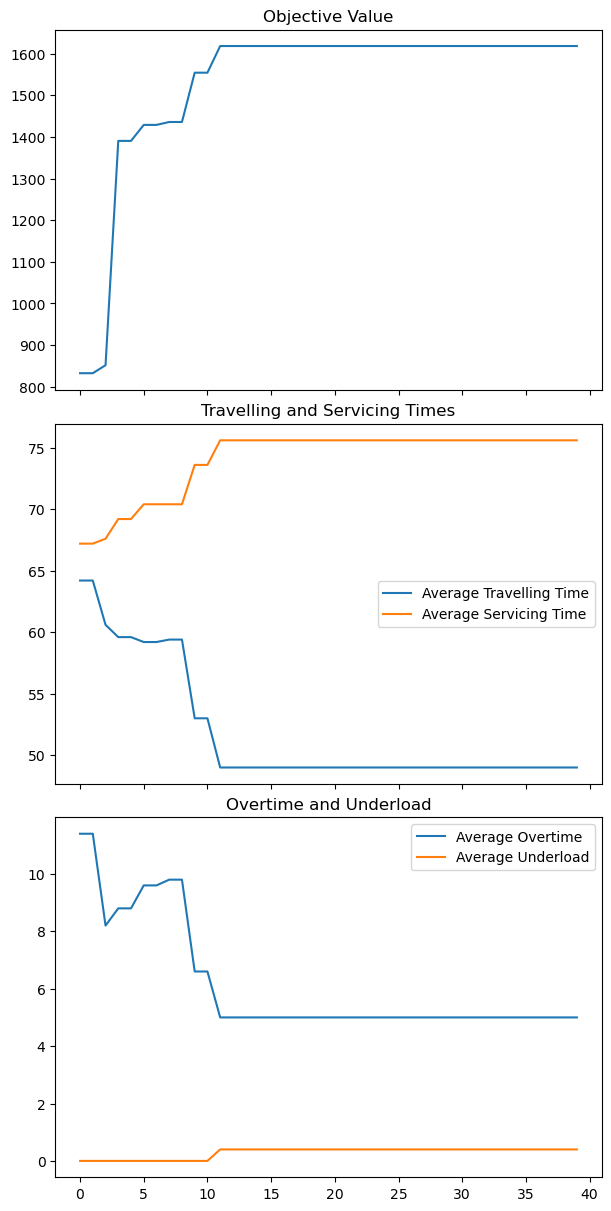

Initial solution:
{'routes': {0: ['F2', 'G2', 'G1', 'E11', 'G11', 'G10'], 1: ['H5', 'G5', 'C5', 'D5', 'B5', 'A11'], 2: ['F7', 'E7', 'C7', 'B9', 'A9', 'A10'], 3: ['B6', 'A6', 'F6', 'E8', 'G8'], 4: ['F3', 'E3', 'D3', 'B3', 'ALG']}, 'overtime': [12.0, 10.0, 2.0, 0, 0], 'requests': [27, 41, 36, 30, 32], 'travelling_time': [78.0, 48.0, 50.0, 50.0, 55.0], 'servicing_time': [54, 82, 72, 60, 64], 'underload': [0, 0, 0, 10.0, 1.0], 'obj_value': -3142.2, 'comp_time': 0}

Optimised solution:
{'routes': {0: ['G1', 'F2', 'G2', 'F2', 'G2', 'F2', 'G2', 'G1'], 1: ['A11', 'B5', 'H5', 'C5', 'B5', 'C5'], 2: ['C7', 'F7', 'C7', 'B9', 'A9', 'B9'], 3: ['F6', 'E8', 'G8', 'E8', 'G8', 'E8', 'F6'], 4: ['F3', 'E3', 'F3', 'E3', 'F3', 'E3', 'F3']}, 'overtime': [2.0, 15.0, 2.0, 6.0, 0], 'requests': [30, 42, 36, 34, 47], 'travelling_time': [62.0, 51.0, 50.0, 58.0, 24.0], 'servicing_time': [60, 84, 72, 68, 94], 'underload': [0, 0, 0, 0, 2.0], 'obj_value': 1618.2, 'comp_time': 8.397701978683472}

Num. of requests fulfi

In [43]:
# Set up parameters
max_iterations = 40
max_nb_iterations = 60
T_initial = 100
T_final = 0.1
r, alpha, beta, k = 10, 1, 1, 20
max_overtime, max_underload = 15, 5
lmbda = 2
max_neighbourhood = 9

# Set up the initial solution
initial_solution = init_solution(num_vehicles=5, max_overtime=15)

# Perform optimisation
# solution = VNS_algorithm(initial_solution, max_iterations, max_nb_iterations, T_initial, T_final, r, alpha, beta, k, max_overtime, max_underload, max_neighbourhood, lmbda)
# solution = VNS_algorithm_realtime_plot(initial_solution, max_iterations, max_nb_iterations, T_initial, T_final, r, alpha, beta, k, max_overtime, max_underload, max_neighbourhood, lmbda)
solution = VNS_algorithm_plot(initial_solution, max_iterations, max_nb_iterations, T_initial, T_final, r, alpha, beta, k, max_overtime, max_underload, max_neighbourhood, lmbda)

print('Initial solution:')
print(initial_solution, end = '\n\n')
print('Optimised solution:')
print(solution, end = '\n\n')
print('Num. of requests fulfilled:', sum(solution['requests']))

# Set up the LNS algorithm

In [33]:
# # Set up a function for removing part of the solution
# def remove_part_of_solution(solution, num_vehicles, request_wards=requests_wards, DG=DG):
#     new_solution = solution
#     i = np.random.randint(0, num_vehicles)
#     j = np.random.randint(0, len(new_solution['routes'][i]))


In [34]:
# # Set up the LNS algorithm
# def LNS(solution, r, alpha, beta, k, max_overtime, num_vehicles, shift_time, DG=DG, request_wards=requests_wards):
#     # Set up the initial solution
#     best_solution = deepcopy(solution)
#     best_objective_function = objective_function(solution, r, alpha, beta, k, max_overtime)
#     # Set up the parameters for the LNS
#     num_iterations = 100
#     num_neighbourhood = 10
#     num_neighbourhood_size = 10
#     # Set up the parameters for the local search
#     num_local_search = 100
#     # Set up Simulated Annealing
#     T = 100
#     T_min = 1
#     alpha = 0.9
#     # Start the LNS
#     while T > T_min:
#         # Select and remove a random number of wards from a random route
#         for i in range(num_iterations):
#             # Select a random route
#             random_route = np.random.randint(0, num_vehicles, size=(1, 1))[0][0]
#             # Select a random number of wards to be removed from the route
#             random_neighbourhood_size = np.random.randint(1, num_neighbourhood_size, size=(1, 1))[0][0]
#             # Select a random number of wards to be removed from the route
#             random_neighbourhood = np.random.choice(solution['routes'][random_route], random_neighbourhood_size, replace=False)
#             # Remove the wards from the route
#             for ward in random_neighbourhood:
#                 solution['routes'][random_route].remove(ward)
#             # Set up the initial solution
#             solution = init_solution(request_wards=request_wards, num_vehicles=num_vehicles, shift_time=shift_time, DG=DG)
#             # Start the local search
#             for j in range(num_local_search):
#                 # Select a random route
#                 random_route = np.random.randint(0, num_vehicles, size=(1, 1))[0][0]
#                 # Select a random ward from the route
#                 random_ward = np.random.choice(solution['routes'][random_route], 1, replace=False)[0]
#                 # Remove the ward from the route
#                 solution['routes'][random_route].remove(random_ward)
#                 # Set up the initial solution
#                 solution = init_solution(request_wards=request_wards, num_vehicles=num_vehicles, shift_time=shift_time, DG=DG)
#                 # Calculate the objective function
#                 objective_function_value = objective_function(solution, r, alpha, beta, k, max_overtime)
#                 # Calculate the difference between the current objective function and the best objective function
#                 delta = objective_function_value - best_objective_function
#                 # If the current objective function is better than the best objective function, update the best objective function
#                 if delta < 0:
#                     best_objective_function = objective_function_value
#                     best_solution = solution
#                 # If the current objective function is worse than the best objective function, update the best objective function with a probability
#                 else:
#                     if np.random.rand() < np.exp(-delta / T):
#                         best_objective_function = objective_function_value
#                         best_solution = solution
#         # Update the temperature
#         T = T * alpha
#     return best_solution

# LNS(init_solution(), r, alpha, beta, k, max_overtime, num_vehicles, shift_time)